# Initialization

In [1]:
# Importing libraries
from __future__ import division
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt
import colour 
from scipy import stats

In [2]:
# Constants 
illuminant_RGB = np.array([0.31270, 0.32900])
illuminant_XYZ = np.array([0.34570, 0.35850])

chromatic_adaptation_transform = 'Bradford'

# source: https://colour.readthedocs.io/en/develop/generated/colour.RGB_to_XYZ.html
RGB_to_XYZ_matrix = np.array(
    [[0.41240000, 0.35760000, 0.18050000],
     [0.21260000, 0.71520000, 0.07220000],
     [0.01930000, 0.11920000, 0.95050000]]
)

#source: https://colour.readthedocs.io/en/develop/generated/colour.XYZ_to_RGB.html
XYZ_to_RGB_matrix = np.array(
    [[3.24062548, -1.53720797, -0.49862860],
     [-0.96893071, 1.87575606, 0.04151752],
     [0.05571012, -0.20402105, 1.05699594]]
)

In [3]:
# Functions 
def rgb2xyz(rgb): 
    return colour.RGB_to_XYZ(rgb, illuminant_RGB, illuminant_XYZ, RGB_to_XYZ_matrix,
           chromatic_adaptation_transform) 

def valid_range(x):
    x = np.asarray(x)
    return x * np.logical_and(x <= 1,x >= 0) + 1 * (x >= 1)

def normalized_vector(v):
    return abs(v)/max(abs(v))

def xyz2rgb(xyz):
    _rgb = colour.XYZ_to_RGB(xyz, illuminant_XYZ, illuminant_RGB, XYZ_to_RGB_matrix,
            chromatic_adaptation_transform)  
    return normalized_vector(_rgb)

def xyz2srgb(xyz): 
    colour.XYZ_to_sRGB(xyz/100, illuminant_RGB, chromatic_adaptation_transform)
    
def mix_colors(rgb_list): 
    Xmix, Ymix, Zmix = 0, 0, 0
    for rgb in rgb_list: 
        X,Y,Z = rgb2xyz(rgb)
        Xmix += X
        Ymix += Y 
        Zmix += Z
    return xyz2rgb(np.array([Xmix, Ymix, Zmix]))

def mat2list(mat):
    _list = [] 
    for m in mat:
        for n in m:
            _list.append(n)
    return _list

def distance_point2line(X0,X1,X2):
    # http://mathworld.wolfram.com/Point-LineDistance3-Dimensional.html
    # https://gist.github.com/nim65s/5e9902cd67f094ce65b0
    return np.linalg.norm(np.cross(X0-X1, X0-X2))/np.linalg.norm(X1-X2)

def chromaticity_index(rgb): 
    black = np.array([0,0,0])
    white = np.array([1,1,1])
    return distance_point2line(np.asarray(rgb), black, white)

def distance_from_white(rgb):
    return np.sqrt(np.sum(np.square(1-rgb)))

In [4]:
# Simulation function 
def sim_zone_and_chrom(n_pixels_side, n_trials, zone_sizes, spatial_func, mix_func, chromindex_func):
    N = n_pixels_side
    clridx = []
    for i in range(len(zone_sizes)):
        clrvi = [] 
        r = zone_sizes[i]
        for j in range(n_trials):
            spatial_org = spatial_func(N,N,3) 
            zone_origin = int(N/2-r/2)
            zone = spatial_org[zone_origin:zone_origin+r:1, zone_origin:zone_origin+r, :]
            mixed = mix_func(mat2list(zone))
            index = chromindex_func(mixed)
            clrvi.append(index)
        clridx.append(clrvi)
    return clridx

# Running examples

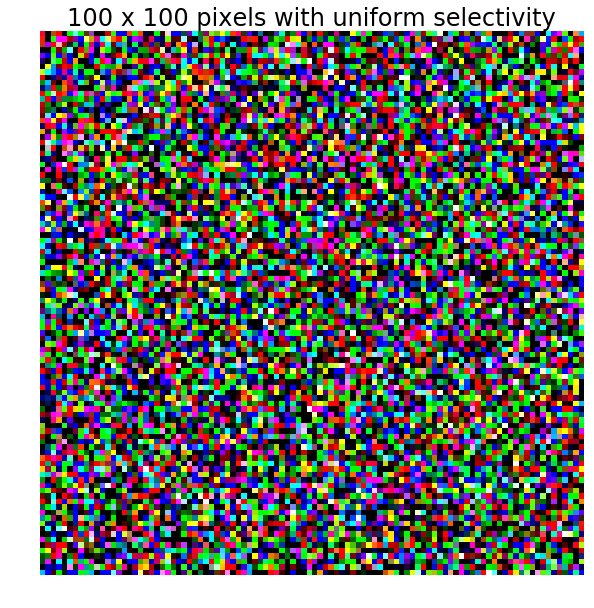

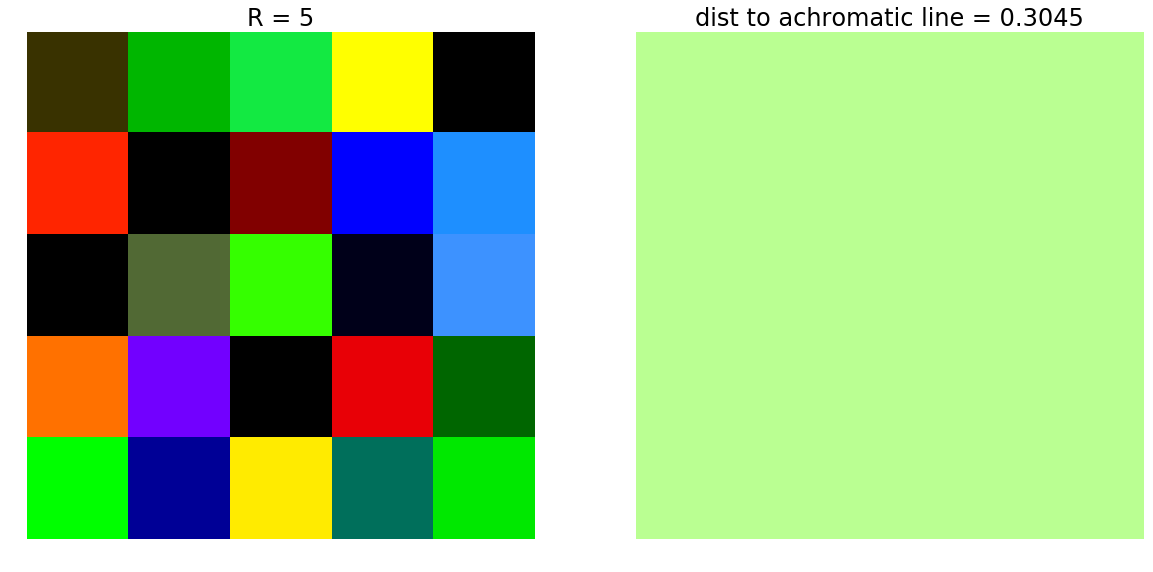

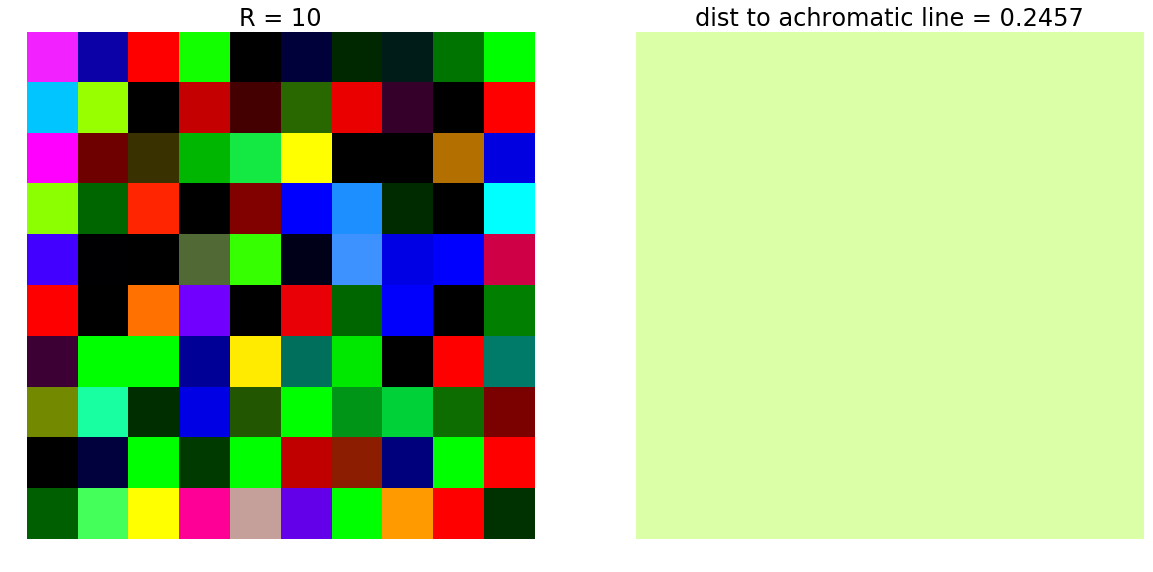

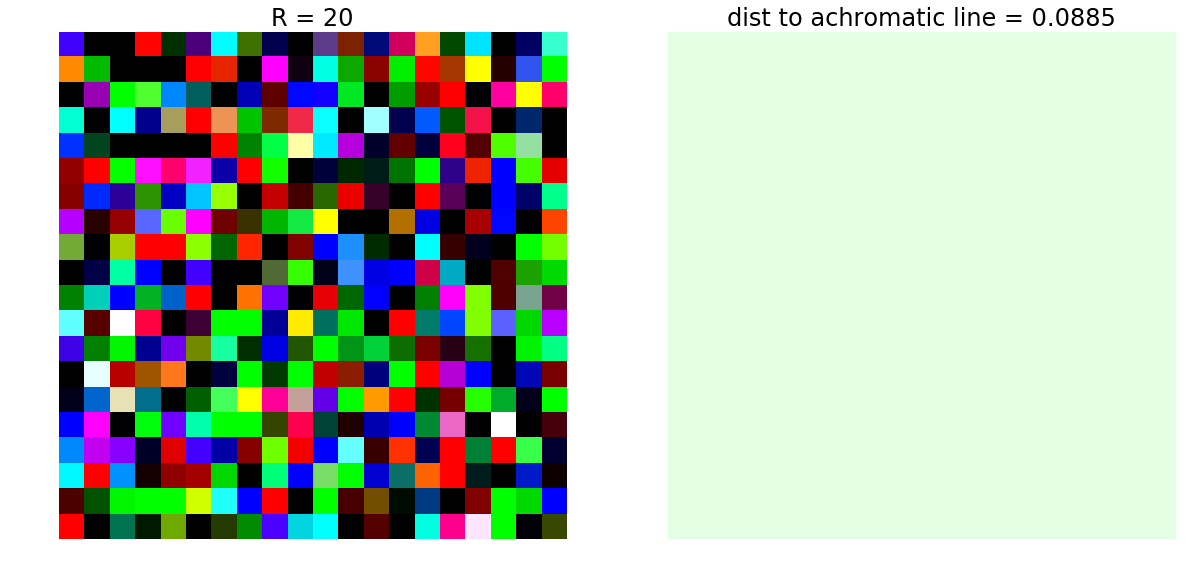

In [17]:
# Benchmark a few examples 
# due to randomization effects, the results will not be exactly as written in reports 
# but the average trend should be similar 
N = 100

img = valid_range(np.random.randn(N,N,3))

plt.figure()
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.family'] = 'Arial'
plt.imshow(img)
plt.axis("off")
plt.title('100 x 100 pixels with uniform selectivity')

for r in [5, 10, 20]:
    zone_origin = int(N/2-r/2)
    zone = img[zone_origin:zone_origin+r:1, zone_origin:zone_origin+r, :]

    plt.figure()
    mpl.rcParams['figure.figsize'] = (20,10)
    mpl.rcParams['font.size'] = 20
    mpl.rcParams['font.family'] = 'Arial'
    
    plt.subplot(1,2,1)
    plt.imshow(zone)
    plt.axis("off")
    plt.title('R = %d' %(r))

    template = np.zeros([100,100,3])
    mixed_color = mix_colors(mat2list(zone))
    template[:,:,:] = mixed_color
    plt.subplot(1,2,2)
    plt.imshow(template)
    plt.axis("off")
    chromidx = chromaticity_index(mixed_color)
    
    plt.title('dist to achromatic line = %.4f' %(chromidx))



# Variation of zone sizes (R)

In [19]:
# Distance from white color vs chrom index vs weighted chromidx 
n_pixels_side = 100 
n_trials = 100
zone_sizes = np.concatenate( (np.arange(1,10),
                              np.arange(10,20,2),
                              np.arange(20,50,5)) )
spatial_func = np.random.rand
mix_func = mix_colors
    
chromindex_func = chromaticity_index
clridx = sim_zone_and_chrom(n_pixels_side, n_trials, zone_sizes, spatial_func, mix_func, chromindex_func) 

([<matplotlib.axis.YTick at 0x7f867df2e850>,
 <a list of 5 Text yticklabel objects>)

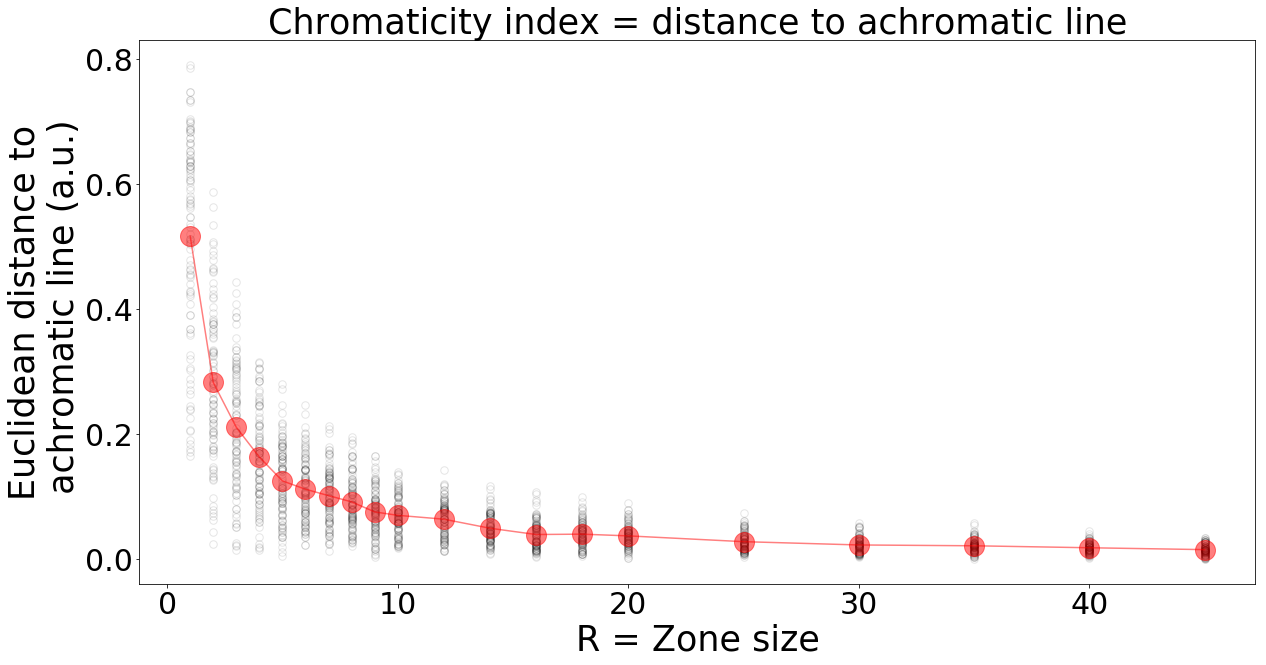

In [20]:
plt.figure()
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rcParams['font.size'] = 30
mpl.rcParams['font.family'] = 'Arial'
mean_clridx = np.zeros(np.size(zone_sizes))
for i in range(len(zone_sizes)):
    idx_arr = np.asarray(clridx[i])
    mean_clridx[i] = np.mean(idx_arr) 
    plt.plot(zone_sizes[i]*np.ones(n_trials), idx_arr, 'k.', alpha = 0.1, markersize = 15, fillstyle='none')
plt.plot(zone_sizes, mean_clridx, '-ro', markersize=20, alpha = 0.5)  

plt.title('Chromaticity index = distance to achromatic line', fontsize=35)
plt.xlabel('R = Zone size', fontsize=35)
plt.ylabel('Euclidean distance to\n achromatic line (a.u.)', fontsize=35)
plt.yticks([0,0.2,0.4,0.6,0.8])
